<a href="https://colab.research.google.com/github/envirodatascience/final-project-go-squirrels/blob/main/Meryl_Squirrels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Our group is investigating what factors may affect squirrel composition and behavior in Central Park based off of a squirrel census conducted in 2018. Specifically, we are going to analyze a set of subquestions: (1) How many nut-producing trees are in Central Park? Where are they located? Do squirrels strategically cluster around these trees? (2) Are squirrels behavior altered around nut-producting trees? (3) Does the weather affect squirrel behavior? Or the number of squirrels seen in a day? (4) Is there a difference in squirrel distribution based on how busy an area of Central Park is?

This part of the project introduces the 2018 Squirrel Census data to the reader, displaying maps and charts about the squirrels' fur color and activities. This notebook also investigates Question 4: Is there a difference in squirrel distribution based on how busy an area of Central Park is?

#Part 1: Import Packages

In [1]:
# Basic
import pandas as pd
import numpy as np

# Plotting
from plotnine import *
import plotnine
from mizani.formatters import scientific_format, percent_format, currency_format

# Stats
import statsmodels.api as sm
import scipy.stats as stats

# geo
import geopandas as gpd
from shapely.geometry import Polygon

#Part 2: Upload Data

In [2]:
url = 'https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250408.csv'
df_sq = pd.read_csv(url)
df_sq.head()


,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


In [3]:
df_sq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           3023 non-null   float64
 1   Y                                           3023 non-null   float64
 2   Unique Squirrel ID                          3023 non-null   object 
 3   Hectare                                     3023 non-null   object 
 4   Shift                                       3023 non-null   object 
 5   Date                                        3023 non-null   int64  
 6   Hectare Squirrel Number                     3023 non-null   int64  
 7   Age                                         2902 non-null   object 
 8   Primary Fur Color                           2968 non-null   object 
 9   Highlight Fur Color                         1937 non-null   object 
 10  Combination 

In [4]:
df_sq['Primary Fur Color'].unique()

array([nan, 'Gray', 'Cinnamon', 'Black'], dtype=object)

In [5]:
df_sq['Highlight Fur Color'].unique()

array([nan, 'Cinnamon', 'White', 'Gray', 'Cinnamon, White', 'Gray, White',
       'Black, Cinnamon, White', 'Black', 'Black, White',
       'Black, Cinnamon', 'Gray, Black'], dtype=object)

In [6]:
df_sq['Combination of Primary and Highlight Color'].unique()

array(['+', 'Gray+', 'Gray+Cinnamon', 'Cinnamon+White', 'Gray+White',
       'Cinnamon+Gray', 'Gray+Cinnamon, White', 'Cinnamon+Gray, White',
       'Gray+Black, Cinnamon, White', 'Cinnamon+', 'Black+', 'Gray+Black',
       'Black+White', 'Black+Cinnamon', 'Gray+Black, White',
       'Cinnamon+Black', 'Black+Gray', 'Gray+Black, Cinnamon',
       'Black+Cinnamon, White', 'Cinnamon+Black, White',
       'Black+Gray, White', 'Cinnamon+Gray, Black'], dtype=object)

In [7]:
#Convert the Squirrel DataFrame to a GeoDataFrame (ZAYA)
df_sq = gpd.GeoDataFrame(
    df_sq,
    geometry=gpd.points_from_xy(df_sq.X, df_sq.Y),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

In [8]:
df_sq.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,geometry
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086),POINT (-73.95613 40.79408)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444),POINT (-73.96886 40.78378)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083),POINT (-73.97428 40.77553)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029),POINT (-73.95964 40.79031)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894),POINT (-73.97027 40.77621)


<Axes: >

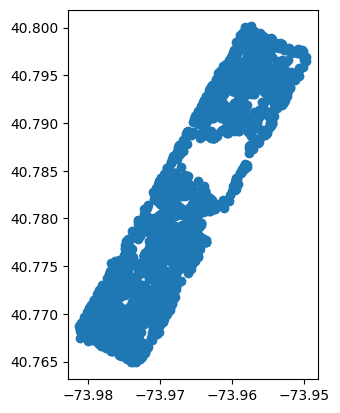

In [9]:
df_sq.plot()

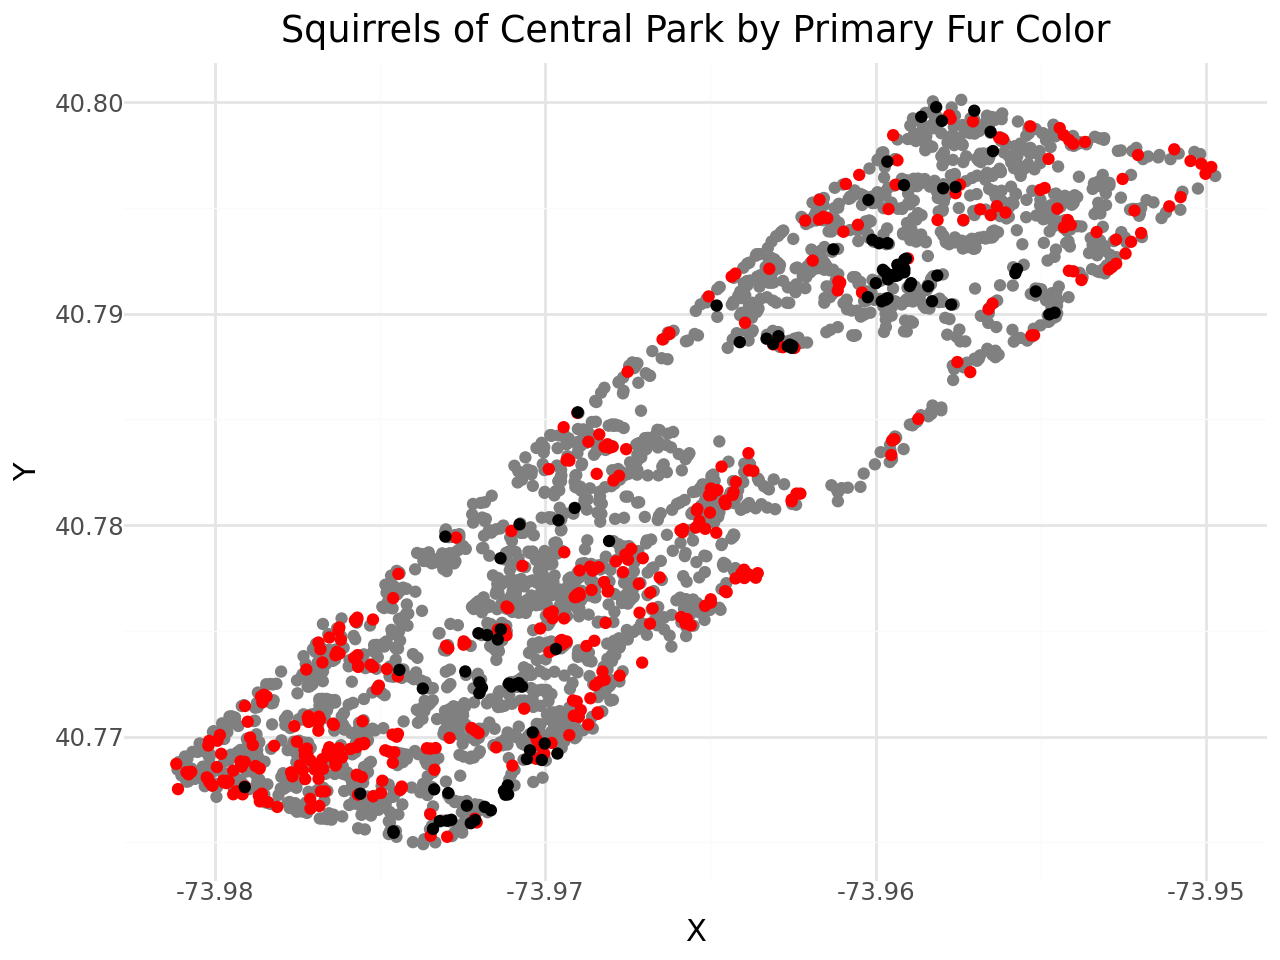

In [10]:
#Map squirrels based on color
(
    ggplot()
    + geom_point(df_sq[df_sq['Primary Fur Color'] == 'Gray'], aes(x='X', y='Y'), color='grey')
    + geom_point(df_sq[df_sq['Primary Fur Color'] == 'Cinnamon'], aes(x='X', y='Y'), color='red')
    + geom_point(df_sq[df_sq['Primary Fur Color'] == 'Black'], aes(x='X', y='Y'), color='black')
    + theme_minimal()
    + labs(title="Squirrels of Central Park by Primary Fur Color")
)

/usr/local/lib/python3.11/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 55'. Pick better value with 'binwidth'.


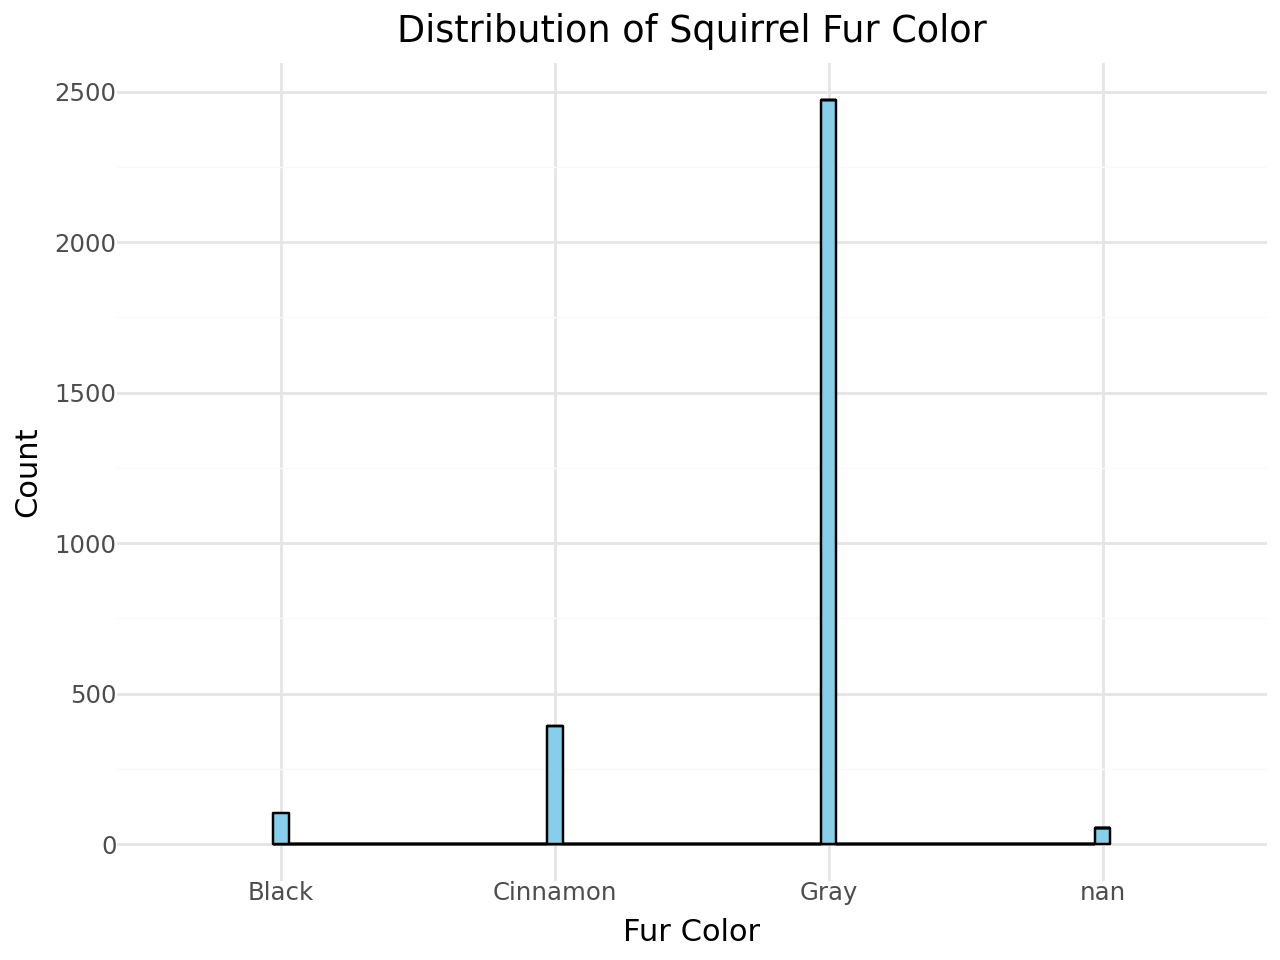

In [11]:
# prompt: make a histogram of squirrel count by fur color

# Create the histogram
(
    ggplot(df_sq, aes(x='Primary Fur Color'))
    + geom_histogram(fill='skyblue', color='black')
    + labs(title='Distribution of Squirrel Fur Color', x='Fur Color', y='Count')
    + theme_minimal()
)


In [12]:
#Bring in hectare data
link = 'https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/2018_Central_Park_Squirrel_Census_-_Hectare_Data_20250421.csv'
df_hect = pd.read_csv(link)
df_hect.head()

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting
0,01A,AM,10072018,110.0,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0
1,01A,PM,10142018,177.0,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0
2,01B,AM,10122018,11.0,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0
3,01B,PM,10192018,109.0,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0
4,01C,PM,10132018,241.0,"55° F, Partly Cloudy",NaN,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0


In [13]:
df_hect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        700 non-null    object 
 1   Shift                          700 non-null    object 
 2   Date                           700 non-null    int64  
 3   Anonymized Sighter             700 non-null    float64
 4   Sighter Observed Weather Data  681 non-null    object 
 5   Litter                         319 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         668 non-null    object 
 8   Hectare Conditions             660 non-null    object 
 9   Hectare Conditions Notes       74 non-null     object 
 10  Number of sighters             700 non-null    int64  
 11  Number of Squirrels            700 non-null    int64  
 12  Total Time of Sighting         680 non-null    flo

In [14]:
df_hect['Other Animal Sightings'].unique()

array(['Humans, Pigeons', 'Humans, Dogs, Pigeons, Horses',
       'Humans, Dogs, Pigeons, Sparrow, Blue jay',
       'Humans, Dogs, Pigeons, Birds', 'Humans', 'Humans, Dogs, Ducks',
       'Humans, Dogs, Cats, Raccoons',
       'Humans, Dogs, Pigeons, Ducks, Bluejay, Sparrow, Starling',
       'Humans, Pigeons, Small birds', 'Humans, Dogs',
       'Humans, Dogs, Pigeons, Downy Woodpecker, Sparrows',
       'Humans, Small birds', 'Humans, Hawks, Dogs',
       'Humans, Pigeons, Mice', 'Humans, Pigeons, Ducks, Geese', nan,
       'Humans, Dogs, Birds', 'Humans, Dogs (off-leash)', 'Humans, Birds',
       'Humans, Dogs, Pigeons',
       'Humans, Dogs, Ducks, Cardinal, Small birds, Robin',
       'Humans, Dogs, Birds, but not pigeons', 'Humans, Dogs, Sparrows',
       'Humans, Dogs, Blue Jays', 'Humans, Dogs, Small birds, Dogs',
       'Humans, Dogs, Birds, Song birds and Crows',
       'Humans, Dogs, Pigeons, Rat',
       'Humans, Dogs, Sparrows, Starlings, American robins',
       'Humans,

In [15]:
df_hect['Hectare Conditions'].unique()

array(['Busy', 'Calm', nan, 'Moderate', 'Calm, Busy', 'Medium'],
      dtype=object)

In [16]:
df_hect['Hectare Conditions'].value_counts()

,count
Hectare Conditions,
Busy,362
Calm,253
Moderate,26
"Calm, Busy",18
Medium,1


In [17]:
#Create dummy variables for busy and calm - First filter for Busy and Calm
df_hect_filtered = df_hect[(df_hect['Hectare Conditions'] == 'Busy')|(df_hect['Hectare Conditions']== 'Calm')]
df_hect_filtered['Hectare Conditions'].value_counts()

,count
Hectare Conditions,
Busy,362
Calm,253


In [18]:
df_hect_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 698
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        615 non-null    object 
 1   Shift                          615 non-null    object 
 2   Date                           615 non-null    int64  
 3   Anonymized Sighter             615 non-null    float64
 4   Sighter Observed Weather Data  606 non-null    object 
 5   Litter                         300 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         602 non-null    object 
 8   Hectare Conditions             615 non-null    object 
 9   Hectare Conditions Notes       49 non-null     object 
 10  Number of sighters             615 non-null    int64  
 11  Number of Squirrels            615 non-null    int64  
 12  Total Time of Sighting         605 non-null    float64


In [19]:
df_hect_filtered['Conditions Score'] = np.where(df_hect_filtered['Hectare Conditions']=='Calm', 0, 1)
df_hect_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 698
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        615 non-null    object 
 1   Shift                          615 non-null    object 
 2   Date                           615 non-null    int64  
 3   Anonymized Sighter             615 non-null    float64
 4   Sighter Observed Weather Data  606 non-null    object 
 5   Litter                         300 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         602 non-null    object 
 8   Hectare Conditions             615 non-null    object 
 9   Hectare Conditions Notes       49 non-null     object 
 10  Number of sighters             615 non-null    int64  
 11  Number of Squirrels            615 non-null    int64  
 12  Total Time of Sighting         605 non-null    float64


<ipython-input-19-9d8f0af0e848>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
df_hect_filtered['Conditions Score'].value_counts()

,count
Conditions Score,
1,362
0,253


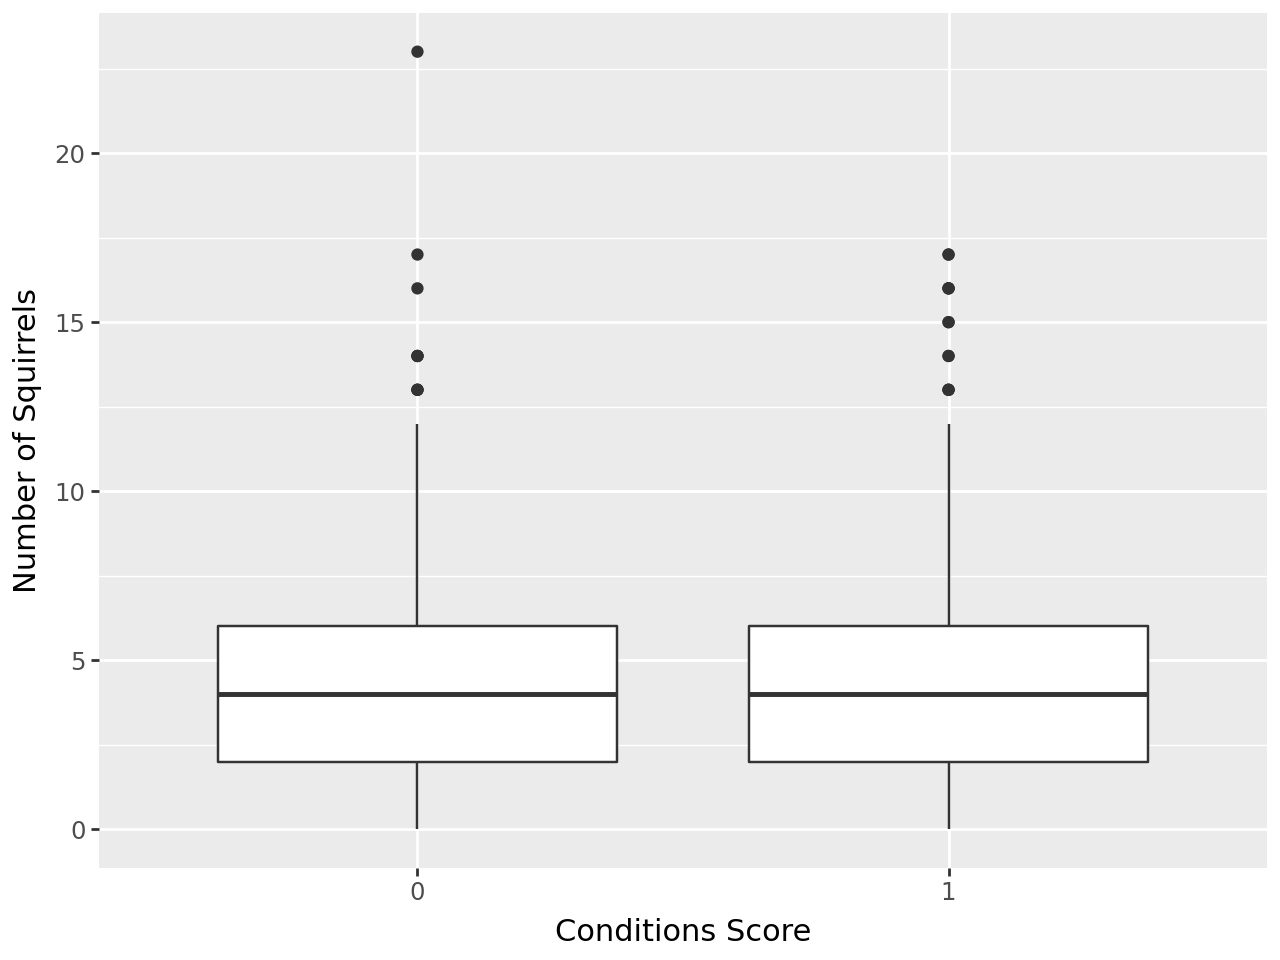

In [21]:
#High level look at Conditions and Squirrel Count
df_chart = df_hect_filtered.copy()
df_chart['Conditions Score'] = df_chart['Conditions Score'].astype('str')

(
    ggplot(df_chart, aes(x='Conditions Score', y='Number of Squirrels'))
    + geom_boxplot()
)

In [22]:
#Summarize further
df_hect_filtered.groupby('Conditions Score').agg(value_count = ('Conditions Score', 'count'), avg_sq_number = ('Number of Squirrels', 'mean'), max_sq = ('Number of Squirrels', 'max'), min_sq = ('Number of Squirrels', 'min'))

,value_count,avg_sq_number,max_sq,min_sq
Conditions Score,,,,
0,253,4.470356,23,0
1,362,4.232044,17,0


In [23]:
# Define Variables
X = df_hect_filtered['Number of Squirrels']
Y = df_hect_filtered['Conditions Score']

# Define model
model = sm.Logit(Y, X)

# Fit model
model_result = model.fit()

# print results
print(model_result.summary2())

Optimization terminated successfully.
         Current function value: 0.686374
         Iterations 4
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: Conditions Score Pseudo R-squared: -0.013  
Date:               2025-04-23 14:20 AIC:              846.2395
No. Observations:   615              BIC:              850.6611
Df Model:           0                Log-Likelihood:   -422.12 
Df Residuals:       614              LL-Null:          -416.57 
Converged:          1.0000           LLR p-value:      nan     
No. Iterations:     4.0000           Scale:            1.0000  
---------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------
Number of Squirrels 0.0419   0.0147 2.8526 0.0043 0.0131 0.0707

